# LDDMM Examples

In this file we run image matching LDDMM on several examples, and demonstrate the utilities in lddmm.py.

The only special functions LDDMM needs to run are

1. Interpolation
1. FFT
1. Gradient



## Library imports
We start by importing necessary libraries.  That includes numpy, matplotlib, and tensorflow for numerical work, nibabel for loading neuroimages, and lddmm and vis which are part of this library.

In [1]:
import numpy as np # for arrays
%matplotlib notebook
import matplotlib as mpl # for graphics
import matplotlib.pyplot as plt
import nibabel as nib # for loading neuroimages
import lddmm # algorithm
import vis # visualization
import tensorflow as tf

Importing helper functions
importing vis


## Development
During development, we have to reimport any libraries we are working on.

In [2]:
# for development
import imp
vis = imp.reload(vis)
lddmm = imp.reload(lddmm)

importing vis
Importing helper functions


## Example data
We will start with some human MRI as example data.  These are two atlases from mricloud.org.  We will deform the atlas to match the target.

In [ ]:
# get filenames
atlas_image_fname = 'Adt27-55_02_Adt27-55_02_MNI.img'
target_image_fname = 'Adt27-55_03_Adt27-55_03_MNI.img'

In [ ]:
# load them with nibabel
fnames = [atlas_image_fname,target_image_fname]
img = [nib.load(fname) for fname in fnames]

In [ ]:
# get info about domains
# we assume for this example that we have the same voxel size and same voxel spacing for atlas and target
if '.img' == atlas_image_fname[-4:]:    
    nx = img[0].header['dim'][1:4]
    dx = img[0].header['pixdim'][1:4]
else:
    # I'm only working with analyze for now
    raise ValueError('Only Analyze images supported for now')
x = [np.arange(nxi)*dxi - np.mean(np.arange(nxi)*dxi) for nxi,dxi in zip(nx,dx)]


In [ ]:
# get the images, note they also include a fourth axis for time that I don't want
I = img[0].get_data()[:,:,:,0]
J = img[1].get_data()[:,:,:,0]
# in this example, images are the same size
# this can be enfored after affine registration
# In the future, we can implement different sizes

In [ ]:
# display the data
f = plt.figure()
vis.imshow_slices(I,x=x,fig=f)
f.suptitle('Atlas I')
f.canvas.draw()

In [ ]:
f = plt.figure()
vis.imshow_slices(J,x=x,fig=f)
f.suptitle('Target J')
f.canvas.draw()

## Interpolation
Deformations are compted by interpolating an image at a set of points.  We demonstrate interpolation here:

In [ ]:
do_interp_test = False
do_interp_test = True
if do_interp_test:
    lddmm = imp.reload(lddmm)
    vis = imp.reload(vis)
    # a quick test
    X0,X1,X2 = np.meshgrid(x[0],x[1],x[2],indexing='ij')
    X0tf = tf.constant(X0,dtype=lddmm.dtype)
    X1tf = tf.constant(X1,dtype=lddmm.dtype)
    X2tf = tf.constant(X2,dtype=lddmm.dtype)
    Itf = tf.constant(I,dtype=lddmm.dtype)
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        Id = lddmm.interp3(x[0],x[1],x[2],Itf,X0tf+10,X1tf*1.2,X2tf + X2tf**2*0.005)
        Idnp = Id.eval()
    f = plt.figure()
    vis.imshow_slices(Idnp,x=x,fig=f)
    f.suptitle('Example of transforming by interpolation')
    f.canvas.draw()
    

## Gradient
Gradients are required to know how the energy will change when the image moves a small amount.  We demonstrate this here

In [ ]:
do_grad_test = False
do_grad_test = True
if do_grad_test:
    # a quick test    
    lddmm = imp.reload(lddmm)
    vis = imp.reload(vis)
    Itf = tf.constant(I,dtype=lddmm.dtype)
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        I_0,I_1,I_2 = lddmm.grad3(Itf,dx)
        Ishow = tf.sqrt(I_0**2 + I_1**2 + I_2**2)
        Ishownp = Ishow.eval()
    f = plt.figure()        
    vis.imshow_slices(Ishownp,x=x,fig=f)
    f.canvas.draw()
    

## LDDMM

In [ ]:
lddmm = imp.reload(lddmm)
out = lddmm.lddmm(I,J,
                  niter=50,eL=0.0,eT=0.0,eV=1e-1,
                  sigmaM=1e1,sigmaR=1e0,
                  p=2,a=2.0)

## Example with mouse images


In [ ]:
# get filenames
atlas_image_fname = 'PMD2052_orig_target_STS_clean.img'
target_image_fname = 'PMD3097_orig_target_STS_clean.img'

In [ ]:
# load them with nababel
fnames = [atlas_image_fname,target_image_fname]
img = [nib.load(fname) for fname in fnames]

In [ ]:
# get info about domains
# we assume for this example that we have the same voxel size and same voxel spacing for atlas and target
if '.img' == atlas_image_fname[-4:]:    
    nx = img[0].header['dim'][1:4]
    dx = img[0].header['pixdim'][1:4]
else:
    # I'm only working with analyze for now
    raise ValueError('Only Analyze images supported for now')
x = [np.arange(nxi)*dxi - np.mean(np.arange(nxi)*dxi) for nxi,dxi in zip(nx,dx)]

In [ ]:
# get the images, note they also include a fourth axis for time that I don't want
I = img[0].get_data()[:,:,:,0]
J = img[1].get_data()[:,:,:,0]
# in this example, images are the same size
# this can be enfored after affine registration
# In the future, we can implement different sizes

In [ ]:
# display the data
f = plt.figure()
vis.imshow_slices(I, x=x, fig=f)
f.suptitle('Atlas I')
f.canvas.draw()

In [ ]:
f = plt.figure()
vis.imshow_slices(J,x=x,fig=f)
f.suptitle('Target J')
f.canvas.draw()

In [ ]:
lddmm = imp.reload(lddmm)
vis = imp.reload(vis)

p = 2
sigmaM = 10.0
eT = 1e-5
eL = 5e-7
eV = 1e-3
naffine = 50
niter = 200
sigmaR = 2e-1
# note this works okay but we get oscilation in the cerebellum where things are high contrast
# would be nice to add some better normalization to my gradient
# recall ants sum of square error does grad/(norm grad + c) for some constant c

out = lddmm.lddmm(I, J, 
                  niter=niter, 
                  naffine=naffine,
                  eV = eV,
                  eT = eT,
                  eL = eL,
                  sigmaM=sigmaM, 
                  sigmaR=sigmaR,
                  xI=x,
                  xJ=x,
                  a=(x[0][1]-x[0][0])*2,
                  p=p)

## Example with mouse images and outlier voxels

In [22]:
# get filenames
atlas_image_fname = 'FluoroAtlas_Downsample.img'
atlas_image_fname = 'average_template_50.img'
target_image_fname = '180517_ch1_Downsample.img'

In [23]:
# load them with nababel
fnames = [atlas_image_fname,target_image_fname]
img = [nib.load(fname) for fname in fnames]

In [24]:
# get info about domains
# we assume for this example that we have the same voxel size and same voxel spacing for atlas and target
if '.img' == atlas_image_fname[-4:]:    
    nxI = img[0].header['dim'][1:4]
    dxI = img[0].header['pixdim'][1:4]
    nxJ = img[1].header['dim'][1:4]
    dxJ = img[1].header['pixdim'][1:4]
    # dx's are wrong in headers for this example
    
    #dxJ = [0.025,0.025,0.025];
    dxJ = [0.05,0.05,0.05]
else:
    # I'm only working with analyze for now
    raise ValueError('Only Analyze images supported for now')
xI = [np.arange(nxi)*dxi - np.mean(np.arange(nxi)*dxi) for nxi,dxi in zip(nxI,dxI)]
xJ = [np.arange(nxi)*dxi - np.mean(np.arange(nxi)*dxi) for nxi,dxi in zip(nxJ,dxJ)]


# NOTE that dx here is 1 because header data is incorrect, TO DO update headers

In [25]:
# get the images, note they also include a fourth axis for time that I don't want
I = img[0].get_data()[:,:,:,0]
J = img[1].get_data()[:,:,:,0]
# in this example, images are the same size
# this can be enfored after affine registration
# In the future, we can implement different sizes



In [26]:
# I would like to pad one slice of the allen atlas so that it has zero boundary conditions
zeroslice = np.zeros((nxI[0],1,nxI[2]))
I = np.concatenate((I,zeroslice),axis=1)
nxI = img[0].header['dim'][1:4]
nxI[1] += 1
xI = [np.arange(nxi)*dxi - np.mean(np.arange(nxi)*dxi) for nxi,dxi in zip(nxI,dxI)]

In [27]:
print(xI[0].shape)
print(xI[1].shape)
print(xI[2].shape)
print(I.shape)

(160,)
(265,)
(228,)
(160, 265, 228)


<IPython.core.display.Javascript object>


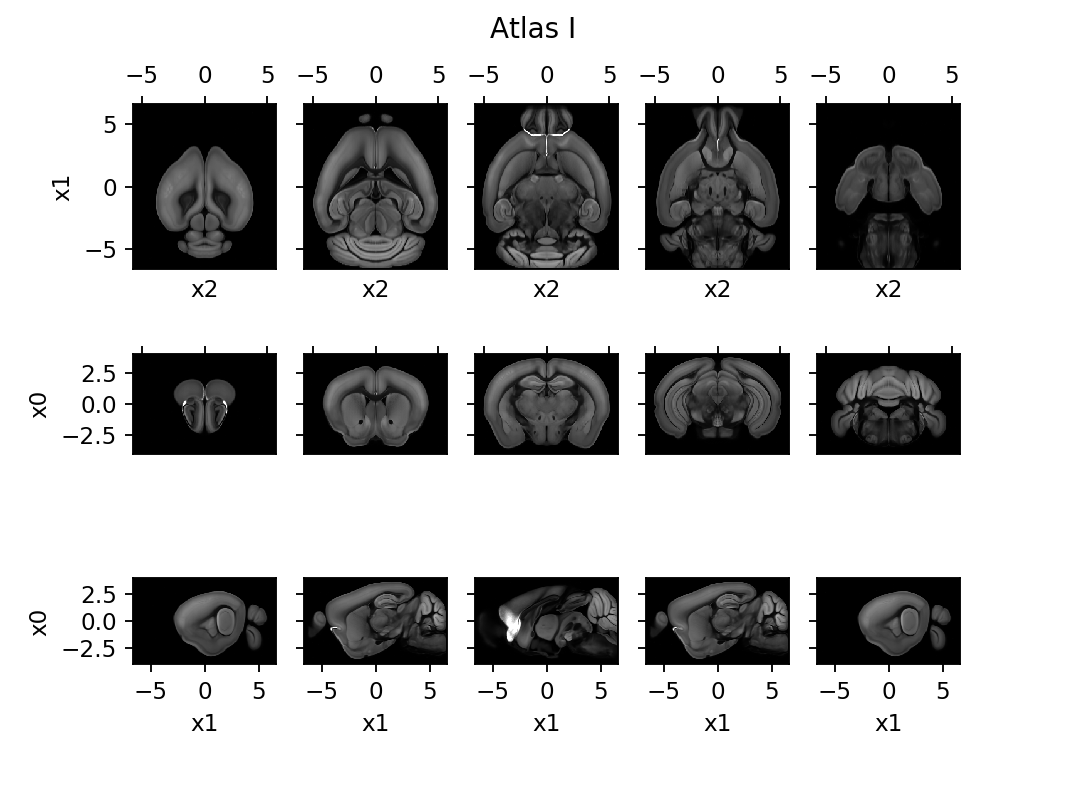

In [28]:
# display the data
f = plt.figure()
vis.imshow_slices(I, x=xI, fig=f)
f.suptitle('Atlas I')
f.canvas.draw()

In [ ]:
f = plt.figure()
vis.imshow_slices(J,x=xJ,fig=f)
f.suptitle('Target J')
f.canvas.draw()

In [29]:
'''
# let's quickly normalize the data
#I = I - np.mean(I)
#I = I / np.std(I)
#
#J = J - np.mean(J)
#J = J / np.std(J)

J = J - 0.0 # make it not be a memmap
Ibar = np.mean(I)
I0 = I - Ibar
Jbar = np.mean(J)
J0 = J - Jbar
VarI = np.mean(I0**2)
#CovIJ = np.mean(I0*J0) # okay this doesn't work because they are different sizes
#Iin = Iin/VarI*CovIJ
#Iin = Iin + np.mean(J) - np.mean(Iin)
VarJ = np.mean(J0**2)
Iin = I * np.sqrt(VarJ / VarI)
Iin = Iin + np.mean(J) - np.mean(Iin)
'''

"\n# let's quickly normalize the data\n#I = I - np.mean(I)\n#I = I / np.std(I)\n#\n#J = J - np.mean(J)\n#J = J / np.std(J)\n\nJ = J - 0.0 # make it not be a memmap\nIbar = np.mean(I)\nI0 = I - Ibar\nJbar = np.mean(J)\nJ0 = J - Jbar\nVarI = np.mean(I0**2)\n#CovIJ = np.mean(I0*J0) # okay this doesn't work because they are different sizes\n#Iin = Iin/VarI*CovIJ\n#Iin = Iin + np.mean(J) - np.mean(Iin)\nVarJ = np.mean(J0**2)\nIin = I * np.sqrt(VarJ / VarI)\nIin = Iin + np.mean(J) - np.mean(Iin)\n"

In [30]:
# the line below is a good initial orientation
A = np.array([[0,0,1,0],
              [-1,0,0,0],
              [0,1,0,0],
              [0,0,0,1]])
A
# for this example we end up about here
'''
A0 = np.array([[ 0.01801422, -0.00215339,  0.9976585 ,  0.20197956],
       [-0.812573  ,  0.00715848,  0.0168141 , -0.04396471],
       [ 0.04159904,  0.9461481 , -0.01636443, -1.0528476 ],
       [ 0.        ,  0.        ,  0.        ,  1.        ]])
'''

'\nA0 = np.array([[ 0.01801422, -0.00215339,  0.9976585 ,  0.20197956],\n       [-0.812573  ,  0.00715848,  0.0168141 , -0.04396471],\n       [ 0.04159904,  0.9461481 , -0.01636443, -1.0528476 ],\n       [ 0.        ,  0.        ,  0.        ,  1.        ]])\n'

<IPython.core.display.Javascript object>


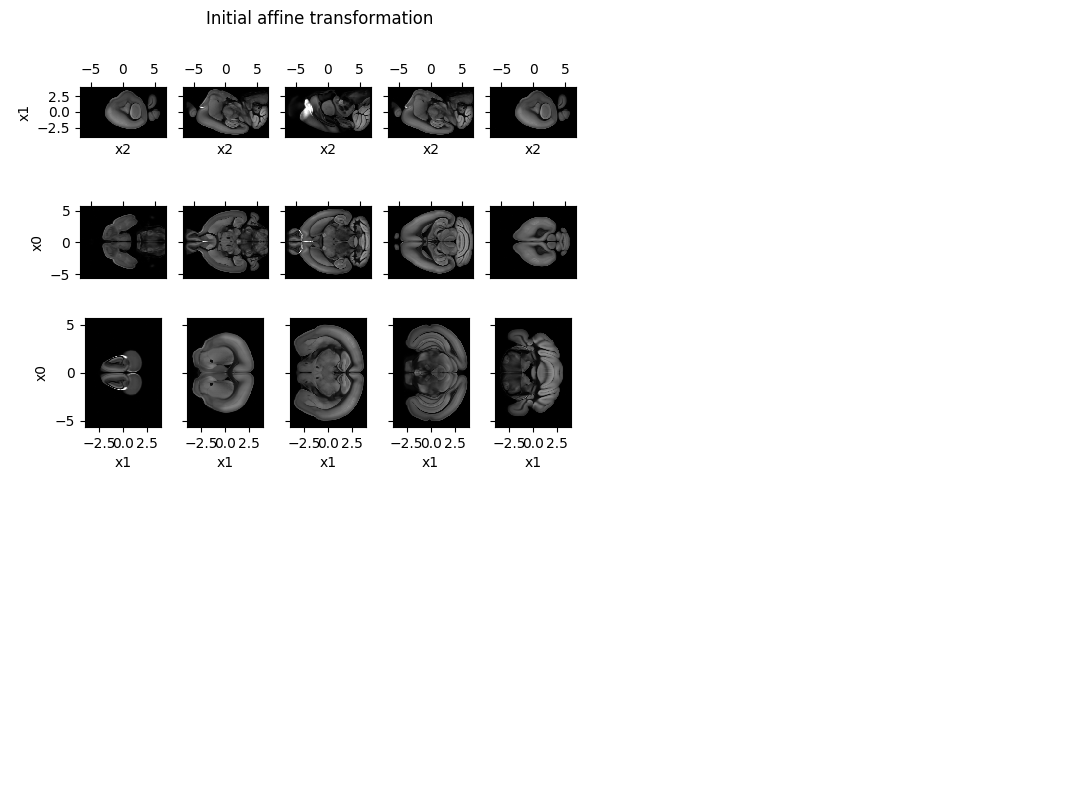

In [31]:
# test the initial affine
initial_affine_test = False
initial_affine_test = True
if initial_affine_test:
    X0,X1,X2 = np.meshgrid(xJ[0],xJ[1],xJ[2],indexing='ij')
    X0tf = tf.constant(X0,dtype=lddmm.dtype)
    X1tf = tf.constant(X1,dtype=lddmm.dtype)
    X2tf = tf.constant(X2,dtype=lddmm.dtype)
    Itf = tf.constant(I,dtype=lddmm.dtype)
    B = np.linalg.inv(A)
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        Xs = B[0,0]*X0tf + B[0,1]*X1tf + B[0,2]*X2tf + B[0,3]
        Ys = B[1,0]*X0tf + B[1,1]*X1tf + B[1,2]*X2tf + B[1,3]
        Zs = B[2,0]*X0tf + B[2,1]*X1tf + B[2,2]*X2tf + B[2,3]
        Id = lddmm.interp3(xI[0], xI[1], xI[2], Itf, Xs, Ys, Zs)
        Idnp = Id.eval()
    f = plt.figure()
    vis.imshow_slices(Idnp,x=xJ,fig=f)
    f.suptitle('Initial affine transformation')
    f.canvas.draw()


Importing helper functions
importing vis
Set default parameters
initial affine transform [[ 0  0  1  0]
 [-1  0  0  0]
 [ 0  1  0  0]
 [ 0  0  0  1]]
Got parameters


<IPython.core.display.Javascript object>


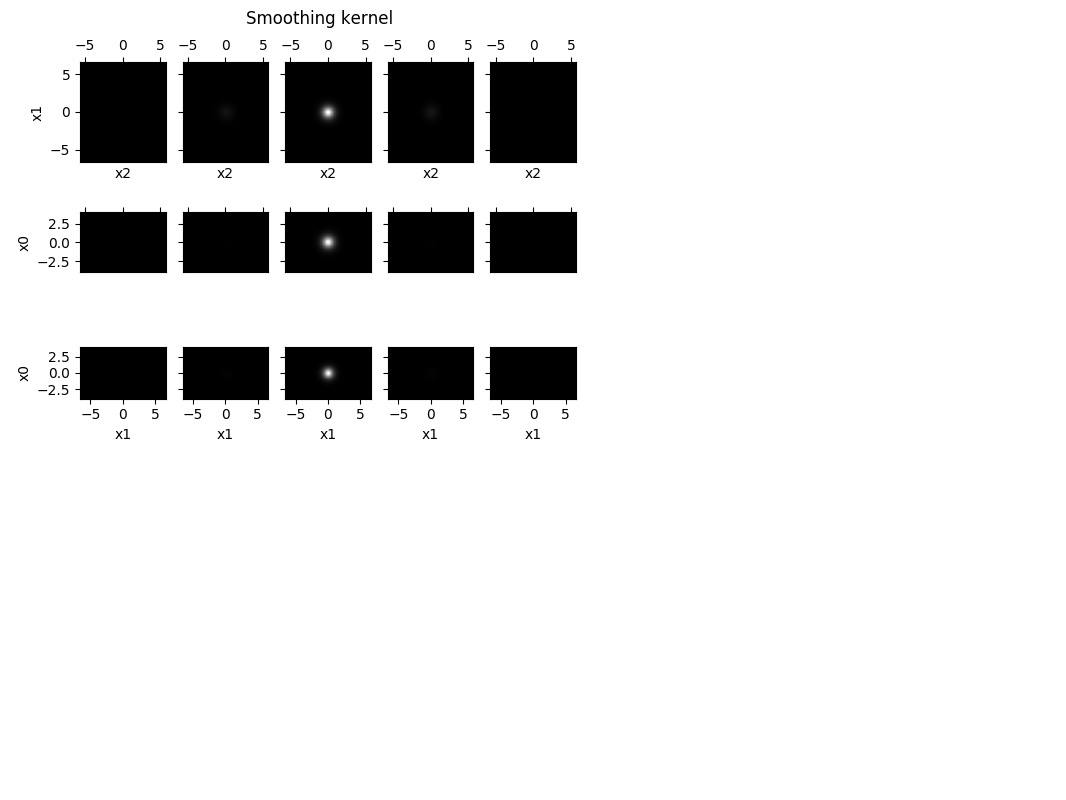

Built energy operators
built tensorflow variables
Computation graph defined


<IPython.core.display.Javascript object>


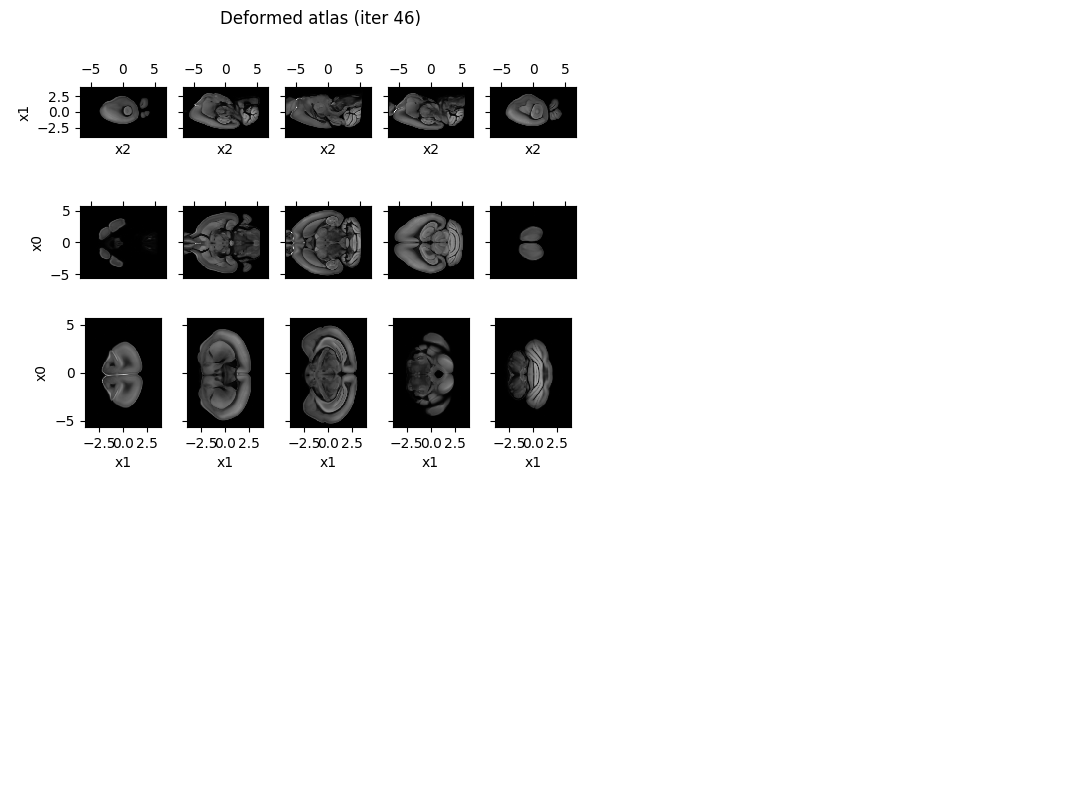

<IPython.core.display.Javascript object>


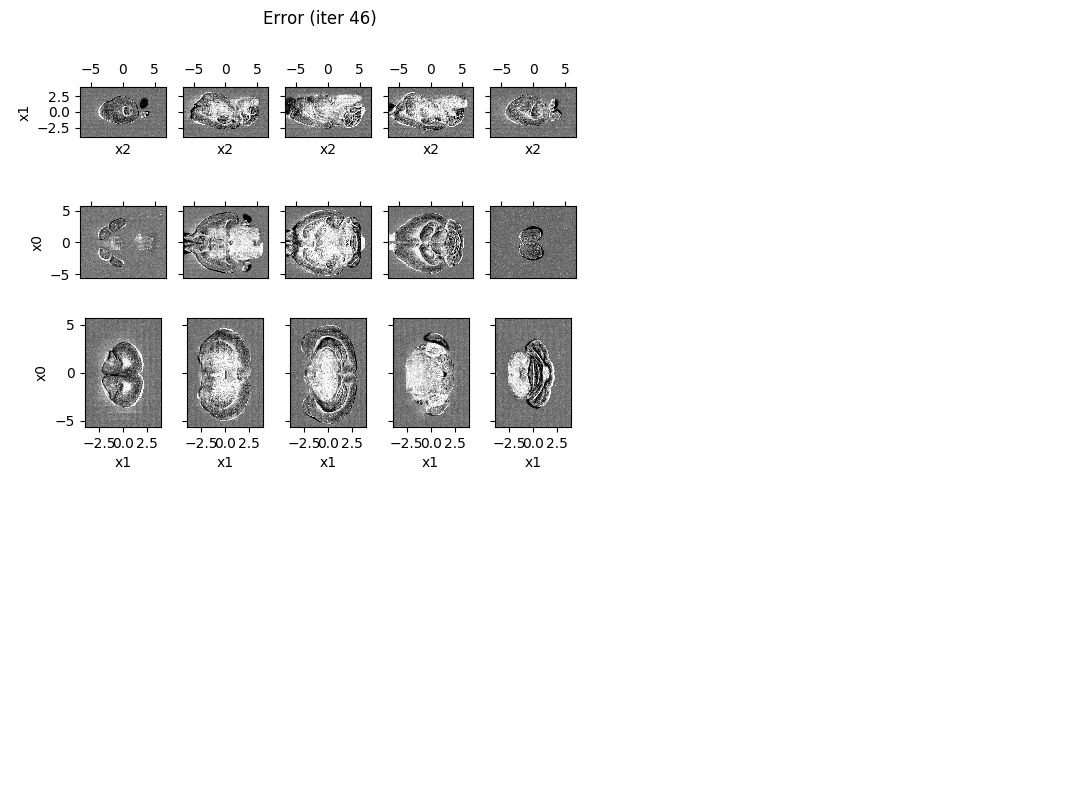

<IPython.core.display.Javascript object>


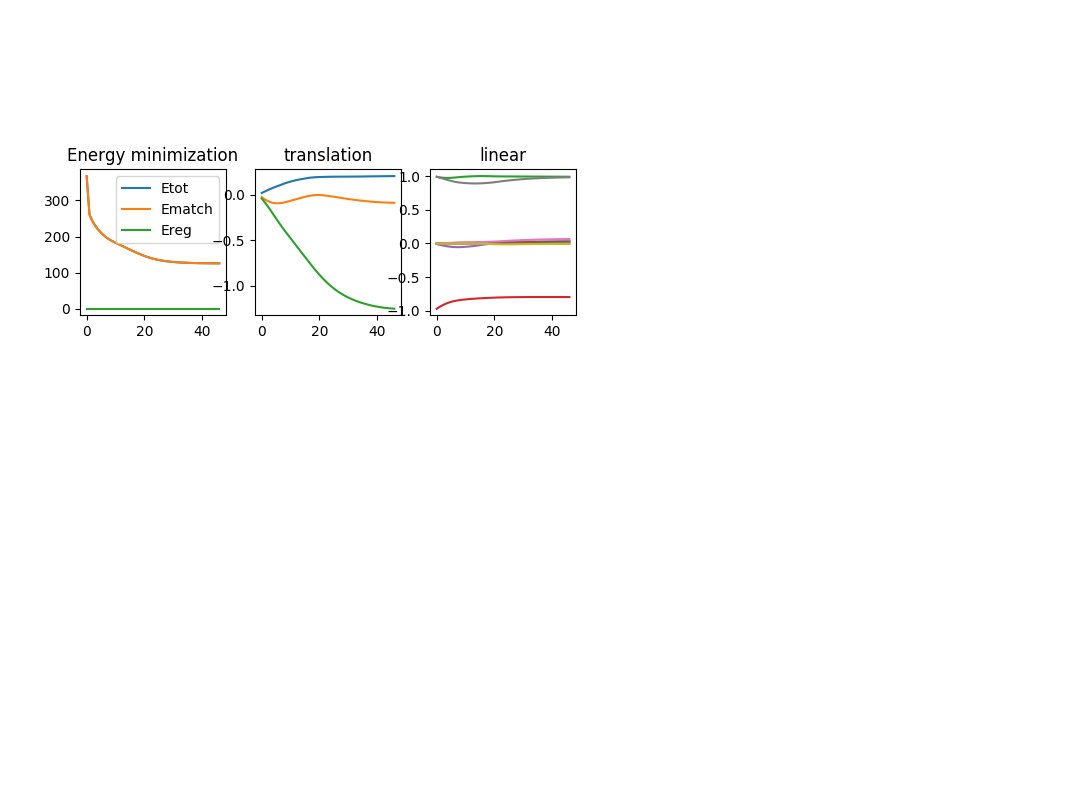

<IPython.core.display.Javascript object>


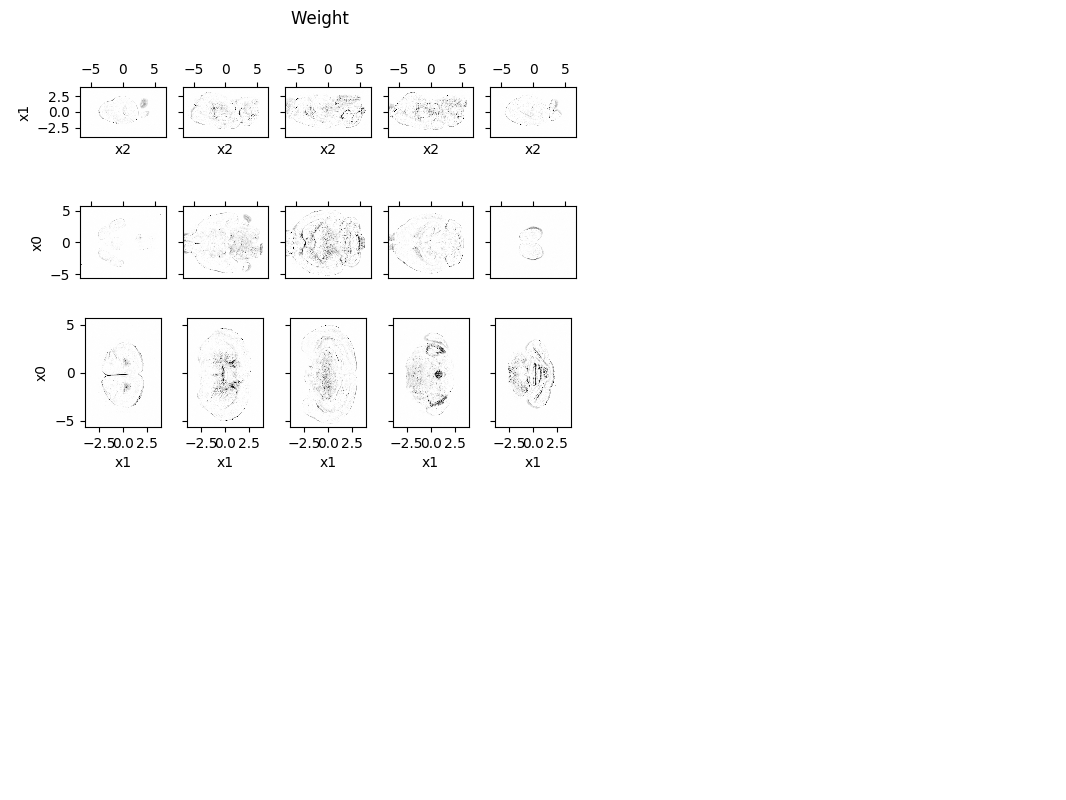

taking affine only step
[[-4.3562139e-04 -5.2349190e-03  9.9070704e-01  1.8653069e-02]
 [-9.7105217e-01 -1.1172376e-02  1.6353196e-04 -2.6670424e-02]
 [ 1.1384704e-03  9.8875296e-01 -2.8777195e-03 -4.0085431e-02]
 [ 0.0000000e+00  0.0000000e+00  0.0000000e+00  1.0000000e+00]]
Updating weights
Finished iteration 0, energy 3.674696e+02 (match 3.674696e+02, reg 0.000000e+00)
taking affine only step
[[-6.4816250e-04 -8.5692424e-03  9.8203695e-01  3.4641743e-02]
 [-9.4431740e-01 -2.1074656e-02 -1.4898831e-05 -4.8707768e-02]
 [ 1.8814765e-03  9.7692710e-01 -4.4787033e-03 -7.9627372e-02]
 [ 0.0000000e+00  0.0000000e+00  0.0000000e+00  1.0000000e+00]]
Updating weights
Finished iteration 1, energy 2.605056e+02 (match 2.605056e+02, reg 0.000000e+00)
taking affine only step
[[-1.1831690e-03 -1.0606393e-02  9.7610903e-01  4.9473286e-02]
 [-9.2014897e-01 -3.0383173e-02  4.7988666e-04 -6.7069471e-02]
 [ 2.8326469e-03  9.6484679e-01 -5.5281939e-03 -1.2205374e-01]
 [ 0.0000000e+00  0.0000000e+00  0.00

[[ 0.01736291 -0.00241742  0.9950513   0.19722722]
 [-0.8014846   0.00354647  0.01680792 -0.0170981 ]
 [ 0.03643507  0.93078744 -0.014243   -1.0010982 ]
 [ 0.          0.          0.          1.        ]]
Updating weights
Finished iteration 24, energy 1.366947e+02 (match 1.366947e+02, reg 0.000000e+00)
taking affine only step
[[ 0.01844656 -0.00224558  0.9949225   0.19767743]
 [-0.8006573   0.00451588  0.01719256 -0.02177221]
 [ 0.03885711  0.9355506  -0.01411419 -1.0268998 ]
 [ 0.          0.          0.          1.        ]]
Updating weights
Finished iteration 25, energy 1.349935e+02 (match 1.349935e+02, reg 0.000000e+00)
taking affine only step
[[ 0.01943233 -0.00211956  0.99482363  0.19792542]
 [-0.79995596  0.00573854  0.01756051 -0.02672042]
 [ 0.04112763  0.9401015  -0.01380728 -1.0504658 ]
 [ 0.          0.          0.          1.        ]]
Updating weights
Finished iteration 26, energy 1.335422e+02 (match 1.335422e+02, reg 0.000000e+00)
taking affine only step
[[ 0.02034908 -0

In [ ]:
lddmm = imp.reload(lddmm)
vis = imp.reload(vis)

# parameters
# cost function weights 1 / sigma^2
sigmaM = np.std(J) # matching
sigmaA = sigmaM*10.0 # artifact
sigmaR = 1e0 # regularization
# enery operator, power of laplacian p, characteristic length a
p = 2
a = (xI[0][1]-xI[0][0])*5
# gradient descent step sizes
eL = 1e-4
eT = 5e-4
eV = 5e-3
# other optimization parameters
niter = 200 # how many iteraitons of gradient descent
naffine = 50 # first naffine iterations are affine only (no deformation)
nt = 5 # this many timesteps to numerically integrate flow
# the linear part is a bit too big still (since I fixed voxel size issue)
# initial guess for affine (check picture above)
A0 = A

# When working with weights in EM algorithm, how many M steps per E step
# first test with 0 (it is working)
nMstep = 5
nMstep_affine = 1

# I think my steps can be bigger for affine
eL = 2e-4
eT = 1e-3



Iin=I
out = lddmm.lddmm(Iin, J, 
                  niter=niter, # iterations of gradient descent
                  naffine=naffine, # iterations of affine only
                  eV = eV, # step size for deformation parameters
                  eT = eT, # step size for translation parameters
                  eL = eL, # step size for linear parameters
                  nt=nt, # timesteps for integtating flow
                  sigmaM=sigmaM, # matching cost weight 1/2sigmaM^2
                  sigmaR=sigmaR, # reg cost weight 1/2sigmaM^2
                  sigmaA=sigmaA, # artifact cost weight 1/2sigmaA^2
                  xI=xI, # location of pixels in domain
                  xJ=xJ,
                  a=a, # kernel width
                  p=p, # power of laplacian in kernel (should be at least 2 for 3D)
                  A0=A0, # initial guess for affine matrix (should get orientation right)
                  nMstep=nMstep, # number of m steps for each e step
                  nMstep_affine=nMstep_affine # number of m steps during affine only phase
                 )

In [ ]:
A0

In [ ]:
np.linalg.det(A0)